In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pyreadr

# Data processing

In [2]:
# Read data
data = pyreadr.read_r('song_data.rds') 
data = data[None]

In [3]:
data['release_year'] = pd.to_datetime(data['release_date']).dt.year
print(data['release_year'])
data_genres_composition = data.where(data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]))
data_genres_composition = data_genres_composition.dropna(how='all')
print(data_genres_composition)
data_genres_composition = data_genres_composition.groupby(['release_year', 'tag']).size().unstack().reset_index()
print(data_genres_composition)
visu_data = data_genres_composition.copy()
data_genres_composition['sum'] = data_genres_composition['folk'] + data_genres_composition['hiphop'] + data_genres_composition['pop'] + data_genres_composition['rock']
data_genres_composition['folk_prop'] = data_genres_composition['folk'] / data_genres_composition['sum']
data_genres_composition['hiphop_prop'] = data_genres_composition['hiphop'] / data_genres_composition['sum']
data_genres_composition['pop_prop'] = data_genres_composition['pop'] / data_genres_composition['sum']
data_genres_composition['rock_prop'] = data_genres_composition['rock'] / data_genres_composition['sum']
print(data_genres_composition)

0        1994
1        2017
2        2015
3        2016
4        2015
         ... 
94811    2012
94812    2015
94813    2015
94814    2016
94815    2015
Name: release_year, Length: 94816, dtype: int64
            song_id   tag release_date  release_month  release_year  \
1       xNgVaKafcd0   pop   2017-09-08    2017.666667        2017.0   
2       mSOdaq656ff  rock   2015-11-11    2015.833333        2015.0   
3      bqv5oMs3aac9   pop   2016-05-24    2016.333333        2016.0   
4       xLBr1fbf8ac   pop   2015-06-27    2015.416667        2015.0   
5      bqwPhDt3af1d   pop   2016-04-14    2016.250000        2016.0   
...             ...   ...          ...            ...           ...   
94811   mSFWvm87f0a   pop   2012-07-12    2012.500000        2012.0   
94812   xNPVxjbf14e   pop   2015-04-08    2015.250000        2015.0   
94813   8IAUlNe26fb   pop   2015-04-08    2015.250000        2015.0   
94814  bCniNa4469b4   pop   2016-04-08    2016.250000        2016.0   
94815   xNPVxla31

## Data visualization

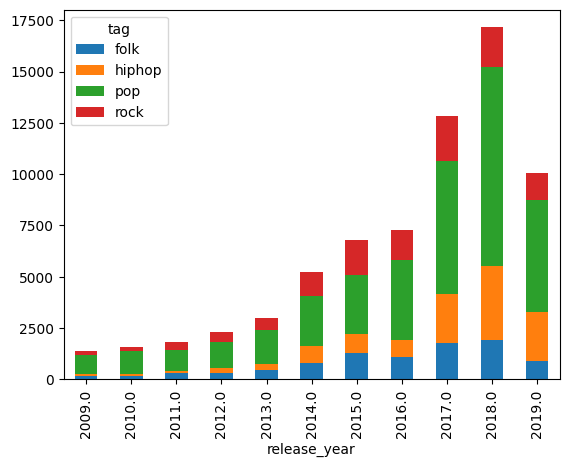

In [4]:
ax = visu_data.plot.bar(x='release_year',stacked=True)
plt.show()

# Machine learning

In [5]:
# ml_data = data[data['release_year'] == 2009].nlargest(50, 'listen_times')
ml_data = data[data['release_year'] == 2009]

# Split data into train and test sets
ml_train, ml_test = train_test_split(ml_data, test_size=0.2, random_state=210016, shuffle=True)

# Select features for training and testing
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]

y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]

## Naive Bayes

In [6]:
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_train_prob = nb_model.predict_proba(ml_train.iloc[:, 1:])
print(np.mean(p_train == ml_train.iloc[:, 0]))
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print(np.mean(p_test == ml_test.iloc[:, 0]))
print(roc_auc_score(y_true, p_test_prob, multi_class='ovr'))

0.6082289803220036
0.6285714285714286
0.7539339972071808


## K-Nearest Neighbors

In [7]:
df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 41):
    print(k)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_model_prob = knn_model.predict_proba(ml_test.iloc[:, 1:])
    y_pred_lab = knn_model.predict(ml_test.iloc[:, 1:])
    acc = np.mean(y_pred_lab == ml_test.iloc[:, 0])
    auc = roc_auc_score(y_true, knn_model_prob, multi_class='ovr')
    # df_knn_auc = df_knn_auc.append({'k': k, 'acc': acc, 'auc': auc}, ignore_index=True)
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
df_knn_auc = df_knn_auc.sort_values(by='acc', ascending=False)
print(df_knn_auc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
    k       acc       auc
0   9  0.760714  0.812217
0   8  0.757143  0.806108
0  11  0.757143  0.805675
0  17  0.753571  0.798068
0  16  0.753571  0.800327
0   6  0.753571  0.783771
0  18  0.750000  0.796110
0  12  0.750000  0.810317
0  30  0.746429  0.797897
0  14  0.746429  0.801806
0  15  0.742857  0.806074
0  26  0.739286  0.802067
0  10  0.739286  0.812230
0  19  0.739286  0.800169
0  20  0.735714  0.797545
0  27  0.735714  0.800991
0  28  0.735714  0.800089
0  31  0.735714  0.799203
0  25  0.735714  0.791698
0  40  0.735714  0.794580
0  39  0.735714  0.794185
0   7  0.732143  0.802957
0  29  0.732143  0.798829
0   3  0.732143  0.770056
0  32  0.732143  0.798421
0  37  0.728571  0.794015
0  36  0.728571  0.796204
0  23  0.728571  0.796533
0  24  0.728571  0.794037
0  35  0.728571  0.793135
0  13  0.728571  0.804100
0  38  0.728571  0.795052
0  33  0.728571  0.797327
0  34

## Random Forest

In [8]:
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(20, 41):
    for max in range(20, 41):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_model_prob = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = np.mean(rf_model.predict(ml_test.iloc[:, 1:]) == ml_test.iloc[:, 0])
        auc = roc_auc_score(y_true, rf_model_prob, multi_class='ovr')
        # df_rf_auc = df_rf_auc.append({'n': n, 'max': max, 'acc': acc, 'auc': auc}, ignore_index=True)
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max, 'acc': acc, 'auc': auc}])])
        # print('depth :',max)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(by='acc', ascending=False)
print(df_rf_auc)

depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 20
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 21
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 22
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 23
depth : 20
depth : 21
depth : 22
depth : 23
dept

## XGBoost

In [9]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 4}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
for iter in range(1, 11):
    param = best_param.copy()
    param['max_depth'] = np.random.randint(2, 6)
    param['eta'] = np.random.uniform(0.01, 0.3)
    seed_number=np.random.randint(10000)
    cv_result = xgb.cv(params=param, dtrain=train_matrix, num_boost_round=1000, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
    print(iter)
nround = best_logloss_index
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)
test_pred = bst_model.predict(test_matrix)
test_prediction = pd.DataFrame(test_pred).apply(lambda x: np.argmax(x), axis=1)
print(np.mean(test_prediction.to_numpy() == ml_test_num.iloc[:, 0].to_numpy()))
print(roc_auc_score(y_true, test_pred, multi_class='ovr'))

1
2
3
4
5
6
7
8
9
10
0.7535714285714286
0.5087954504004019


# Prediction

In [10]:
data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'treatment_date'] = np.where(data_predict.loc[:,'release_date'] < pd.to_datetime('2017-06-24'), 0, 1)
data_predict.loc[:,'treatment_year'] = np.where(data_predict.loc[:,'release_year'] < 2017, 0, 1)

/tmp/ipykernel_4381/1694111673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
/tmp/ipykernel_4381/1694111673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
/tmp/ipykernel_4381/1694111673.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library

## Naive Bayes

In [11]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(data_predict.iloc[:, 6:17])
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']

/tmp/ipykernel_4381/443113763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict.loc[:,'gnb_pred'] = nb_model.predict(data_predict.iloc[:, 6:17])
/tmp/ipykernel_4381/443113763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
/tmp/ipykernel_4381/443113763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



## K-Nearest Neighbors

In [12]:
data_predict['knn_pred'] = knn_model.predict(data_predict.iloc[:, 6:17])
data_predict['knn_pred_acc'] = data_predict['knn_pred'] == data_predict['tag']
data_predict['knn_pred_bin'] = np.where(data_predict['knn_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['knn_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['knn_pred_bin']

/tmp/ipykernel_4381/134867769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['knn_pred'] = knn_model.predict(data_predict.iloc[:, 6:17])
/tmp/ipykernel_4381/134867769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['knn_pred_acc'] = data_predict['knn_pred'] == data_predict['tag']
/tmp/ipykernel_4381/134867769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

## Random Forest

In [13]:
data_predict['rf_pred'] = rf_model.predict(data_predict.iloc[:, 6:17])
data_predict['rf_pred_acc'] = data_predict['rf_pred'] == data_predict['tag']
data_predict['rf_pred_bin'] = np.where(data_predict['rf_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['rf_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['rf_pred_bin']

/tmp/ipykernel_4381/309029341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['rf_pred'] = rf_model.predict(data_predict.iloc[:, 6:17])
/tmp/ipykernel_4381/309029341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['rf_pred_acc'] = data_predict['rf_pred'] == data_predict['tag']
/tmp/ipykernel_4381/309029341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

## XGBoost

In [14]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(data_predict.iloc[:, 6:17]))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: np.argmax(x) + 1, axis=1)
data_predict['xgb_pred_acc'] = data_predict['xgb_pred'] == data_predict['tag']
data_predict['xgb_pred_bin'] = np.where(data_predict['xgb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['xgb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['xgb_pred_bin']

/tmp/ipykernel_4381/1823267812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: np.argmax(x) + 1, axis=1)
/tmp/ipykernel_4381/1823267812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['xgb_pred_acc'] = data_predict['xgb_pred'] == data_predict['tag']
/tmp/ipykernel_4381/1823267812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [15]:
print(data_predict)
print(data_predict.columns)

            song_id   tag release_date  release_month  release_year  \
1       xNgVaKafcd0   pop   2017-09-08    2017.666667          2017   
2       mSOdaq656ff  rock   2015-11-11    2015.833333          2015   
3      bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016   
4       xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015   
5      bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016   
...             ...   ...          ...            ...           ...   
94811   mSFWvm87f0a   pop   2012-07-12    2012.500000          2012   
94812   xNPVxjbf14e   pop   2015-04-08    2015.250000          2015   
94813   8IAUlNe26fb   pop   2015-04-08    2015.250000          2015   
94814  bCniNa4469b4   pop   2016-04-08    2016.250000          2016   
94815   xNPVxla3162   pop   2015-04-08    2015.250000          2015   

       listen_times  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1             952.0          0.313235   0.226911                0.32528

# Metrics

## Naive Bayes

In [16]:
gnb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear    = data_predict.copy()[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
print(gnb_metrics)
print(gnb_metrics.columns)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
print(gnb_metrics)

    release_year  treatment_year  gnb_pred_acc  gnb_pred_bin_acc  gnb_recall  \
0           2009               0      0.612303          0.949928    0.351852   
1           2010               0      0.540745          0.890082    0.087591   
2           2011               0      0.468852          0.902732    0.088496   
3           2012               0      0.492995          0.863398    0.118081   
4           2013               0      0.484879          0.878696    0.105096   
5           2014               0      0.435321          0.830444    0.108209   
6           2015               0      0.427329          0.854805    0.144880   
7           2016               0      0.448048          0.866135    0.117786   
8           2017               1      0.457009          0.818925    0.124736   
9           2018               1      0.477833          0.791087    0.110286   
10          2019               1      0.439056          0.764987    0.111064   

    gnb_precision  
0        0.351852  

## K-Nearest Neighbors

In [17]:
knn_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
knn_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
knn_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
knn_precision_tbyyear    = data_predict.copy()[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
print(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
print(knn_metrics)

    release_year  treatment_year  knn_pred_acc  knn_pred_bin_acc  knn_recall  \
0           2009               0      0.734621          0.961373    0.000000   
1           2010               0      0.686671          0.913455    0.000000   
2           2011               0      0.571038          0.938251    0.000000   
3           2012               0      0.561734          0.881349    0.000000   
4           2013               0      0.570901          0.894489    0.000000   
5           2014               0      0.477043          0.846828    0.000000   
6           2015               0      0.443396          0.864682    0.000000   
7           2016               0      0.534360          0.883315    0.000000   
8           2017               1      0.509735          0.815810    0.000000   
9           2018               1      0.563647          0.788232    0.000275   
10          2019               1      0.545210          0.765087    0.000000   

    knn_precision  
0             1.0  

## Random Forest

In [18]:
rf_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear    = data_predict.copy()[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
print(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
print(rf_metrics)

    release_year  treatment_year  rf_pred_acc  rf_pred_bin_acc  rf_recall  \
0           2009               0     0.948498         0.991416   0.851852   
1           2010               0     0.674037         0.910929   0.124088   
2           2011               0     0.572678         0.930055   0.053097   
3           2012               0     0.585814         0.884413   0.084871   
4           2013               0     0.560148         0.895161   0.070064   
5           2014               0     0.495904         0.850638   0.075871   
6           2015               0     0.460495         0.867188   0.081699   
7           2016               0     0.519516         0.881803   0.063604   
8           2017               1     0.515966         0.825545   0.092178   
9           2018               1     0.557297         0.800816   0.105886   
10          2019               1     0.533260         0.774945   0.102162   

    rf_precision  
0       0.920000  
1       0.447368  
2       0.222222  

## XGBoost

In [19]:
xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
print(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
print(xgb_metrics)

    release_year  treatment_year  xgb_pred_acc  xgb_pred_bin_acc  xgb_recall  \
0           2009               0           0.0          0.961373         0.0   
1           2010               0           0.0          0.913455         0.0   
2           2011               0           0.0          0.938251         0.0   
3           2012               0           0.0          0.881349         0.0   
4           2013               0           0.0          0.894489         0.0   
5           2014               0           0.0          0.846828         0.0   
6           2015               0           0.0          0.864682         0.0   
7           2016               0           0.0          0.883315         0.0   
8           2017               1           0.0          0.815810         0.0   
9           2018               1           0.0          0.788174         0.0   
10          2019               1           0.0          0.765087         0.0   

    xgb_precision  
0             NaN  

## Total

In [20]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
print(average)

    release_year  treatment_year                   metrics         0
0           2009               0      classifiers_pred_acc  0.573856
1           2010               0      classifiers_pred_acc  0.475363
2           2011               0      classifiers_pred_acc  0.403142
3           2012               0      classifiers_pred_acc  0.410136
4           2013               0      classifiers_pred_acc  0.403982
5           2014               0      classifiers_pred_acc  0.352067
6           2015               0      classifiers_pred_acc  0.332805
7           2016               0      classifiers_pred_acc  0.375481
8           2017               1      classifiers_pred_acc  0.370678
9           2018               1      classifiers_pred_acc  0.399694
10          2019               1      classifiers_pred_acc  0.379382
11          2009               0  classifiers_pred_bin_acc  0.966023
12          2010               0  classifiers_pred_bin_acc  0.906980
13          2011               0  